## Import Packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


## Load Data

In [5]:
all_star_games = pd.read_csv('src/NBA_All_Star_Games_195051to201718.csv')
season_stats = pd.read_csv('src/Seasons_Stats.csv')
nba_stats = pd.read_csv('src/nba_stat_merged.csv')

In [6]:
all_star_games.head()

,Year,Player,Pos,HT,WT,Team,Selection Type,NBA Draft Status,Nationality
0,1951,Paul Arizin,GF,6-4,190,San Francisco Warriors,Eastern All-Star Coaches Selection,1950 Rnd 1 Pick 3,United States
1,1951,Vince Boryla,SF,6-5,210,New York Knicks,Eastern All-Star Fan Vote Selection,"1949 NBA Draft, Undrafted",United States
2,1951,Bob Cousy,PG,6-1,175,Boston Celtics,Eastern All-Star Fan Vote Selection,"1950 NBA Draft, Undrafted",United States
3,1951,Joe Fulks,SF,6-5,190,San Francisco Warriors,Eastern All-Star Coaches Selection,"NBA Draft, Undrafted",United States
4,1951,Harry Gallatin,FC,6-6,210,New York Knicks,Eastern All-Star Coaches Selection,1947 Rnd 4 Pick 10,United States


In [7]:
season_stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [8]:
nba_stats.head()

,Year,Player_,Tm,Pos,G,MP,Age,PTS,FG,FG%,...,ORB,ORB%,STL,STL%,TOV,TOV%,PF,WS,all_star_this_year,all_star_next_year
0,1980.0,Kareem Abdul-Jabbar,LAL,C,82.0,3143.0,32.0,2034.0,835.0,0.604,...,190.0,7.2,81.0,1.2,297.0,15.7,216.0,14.8,1.0,1.0
1,1980.0,Tom Abernethy,GSW,PF,67.0,1222.0,25.0,362.0,153.0,0.481,...,62.0,5.4,35.0,1.4,39.0,9.9,118.0,2.0,0.0,0.0
2,1980.0,Alvan Adams,PHO,C,75.0,2168.0,25.0,1118.0,465.0,0.531,...,158.0,8.2,108.0,2.3,218.0,18.2,237.0,7.0,0.0,0.0
3,1980.0,Tiny Archibald,BOS,PG,80.0,2864.0,31.0,1131.0,383.0,0.482,...,59.0,2.3,106.0,1.7,242.0,19.7,218.0,8.9,1.0,1.0
4,1980.0,Dennis Awtrey,CHI,C,26.0,560.0,31.0,86.0,27.0,0.450,...,29.0,6.0,12.0,1.0,27.0,24.8,66.0,0.6,0.0,0.0


## Clean Data

<ul>
<li> Objective: predict the W/S of the next season </li> 
<ul>
<li>WS: Win Shares; an estimate of the number of wins contributed by a player.</li>
</ul>
<li>  Lag WS variable back to previous observation </li> 
<li>  Index for each players </li> 
</ul> 

In [9]:
nba_stats.sort_values(['Player_','Year'],inplace=True)
nba_stats['Index_p'] = nba_stats.groupby(['Player_']).cumcount()
nba_copy = nba_stats[['Player_','Index_p','WS']].copy()
nba_copy['Index_p'] = nba_copy['Index_p']  - 1
nba_copy.columns = ['Player_2','Index_p2','WS2']
nba_stats = pd.merge(nba_stats,nba_copy,how='left',left_on=['Player_','Index_p'],right_on=['Player_2','Index_p2'])


nba_stats_rm = nba_stats.dropna(subset=['WS2']).copy()
nba_stats_rm = nba_stats_rm.dropna()

In [10]:
nba_stats_rm.head()

,Year,Player_,Tm,Pos,G,MP,Age,PTS,FG,FG%,...,TOV,TOV%,PF,WS,all_star_this_year,all_star_next_year,Index_p,Player_2,Index_p2,WS2
0,1986.0,A.C. Green,LAL,PF,82.0,1542.0,22.0,521.0,209.0,0.539,...,99.0,17.7,229.0,3.3,0.0,0.0,0,A.C. Green,0.0,7.6
1,1987.0,A.C. Green,LAL,PF,79.0,2240.0,23.0,852.0,316.0,0.538,...,102.0,12.5,171.0,7.6,0.0,0.0,1,A.C. Green,1.0,7.9
2,1988.0,A.C. Green,LAL,PF,82.0,2636.0,24.0,937.0,322.0,0.503,...,120.0,12.9,204.0,7.9,0.0,0.0,2,A.C. Green,2.0,9.4
3,1989.0,A.C. Green,LAL,PF,82.0,2510.0,25.0,1088.0,401.0,0.529,...,119.0,11.5,172.0,9.4,0.0,1.0,3,A.C. Green,3.0,7.7
4,1990.0,A.C. Green,LAL,PF,82.0,2709.0,26.0,1061.0,385.0,0.478,...,116.0,10.7,207.0,7.7,1.0,0.0,4,A.C. Green,4.0,6.1


# Develop Model

### Select data from 1986-2016

In [11]:
nba_8616 =  nba_stats_rm[nba_stats_rm['Year']>1986].copy()


### Split the dataset into training and test sets with a stratified split based on 'Year'

In [12]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=25)
for train_index, test_index in split.split(nba_8616,nba_8616['Year']):
    strat_train_set = nba_8616.iloc[train_index]
    strat_test_set = nba_8616.iloc[test_index]


### Define numerical variables for the model

In [13]:
num_vab = ['G','MP','PTS','FG%','2P%','3P','3P%','FT','FT%',
            'AST','AST%','BLK','BLK%','DRB','DRB%','ORB',
            'STL','STL%','TOV%','PF']

### Variable selection class for pipeline

In [14]:
class vab_select(BaseEstimator,TransformerMixin):
    def __init__(self,feature_names):
        self._feature_names = feature_names
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self._feature_names]

### Numerical pipeline for preprocessing

In [15]:
num_pipeline = Pipeline([('feature_seLect',vab_select(num_vab)),
                         ('data_scaling',MinMaxScaler())])

### Process the original training dataset and the test dataset

In [16]:
x_train_set_processed = num_pipeline.fit_transform(strat_train_set)
y_train_set = strat_train_set['all_star_next_year'].copy()

x_test_set_processed = num_pipeline.transform(strat_test_set)
y_test = strat_test_set['all_star_next_year']


### Split the training dataset into training and validation sets

In [17]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=25)
for train_index, valid_index in split.split(x_train_set_processed,strat_train_set['Year']):
    x_train = x_train_set_processed[train_index]
    y_train = np.array(y_train_set.iloc[train_index])
    x_valid = x_train_set_processed[valid_index]
    y_valid = np.array(y_train_set.iloc[valid_index])

x_train.shape
y_train.shape

(5762,)

## Resampling techniques for handling class imbalance

### Simple oversampling
<li> Separate the all-star and non-all-star </li>
<li> Upsampling: manually adding data samples to the minority classes in order to create a more balanced dataset. </li>
<li> Combining two datasets</li>

In [18]:
all_star = x_train[y_train==1]
non_all_star = x_train[y_train!=1]

all_star_upsampled = resample(all_star,replace=True,n_samples=len(non_all_star),random_state=25)

train_upsampled = np.concatenate((non_all_star,all_star_upsampled))
y_train_upsampled = np.concatenate(([0]*len(non_all_star),[1]*len(all_star_upsampled)))

### SMOTE oversampling
Synthetic Minority Oversampling Technique
<li> Resample the minority class. You can change the strategy to 'auto' if you are not sure.</li>

In [19]:
sm = SMOTE(sampling_strategy='minority', random_state=25)
oversample = SMOTE()
oversampled_trainX, oversampled_trainY = oversample.fit_resample(x_train, y_train)
oversampled_trainX.shape
oversampled_trainY.shape

(10630,)

## Modeling

### Cross Validation

In [20]:
# Import necessary libraries for modeling and evaluation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Define the candidate model: Stochastic Gradient Descent (SGD) Classifier
# SGD is chosen for its efficiency with large datasets and capability for linear classification.
sgd_clf = SGDClassifier(random_state=25)

# OVERSAMPLING TECHNIQUES
# Two oversampling techniques are used to handle class imbalance: Simple Oversampling and SMOTE.

# SIMPLE UPSAMPLING
# Predictions are made using cross-validation to ensure that the model is not overfitting to the training data.
y_train_pred_sgdclf = cross_val_predict(sgd_clf, train_upsampled, y_train_upsampled, cv=5)

# Evaluate the model's performance on the simple oversampled data
# Confusion Matrix: Provides a detailed breakdown of correct vs incorrect classifications
print("Confusion Matrix (Simple Oversampling):")
print(confusion_matrix(y_train_upsampled, y_train_pred_sgdclf))

# Precision: Measures the accuracy of positive predictions.
precision_simple = precision_score(y_train_upsampled, y_train_pred_sgdclf)
print(f"Precision (Simple Oversampling): {precision_simple:.2f}")

# Recall: Measures the ratio of positive instances that are correctly detected.
recall_simple = recall_score(y_train_upsampled, y_train_pred_sgdclf)
print(f"Recall (Simple Oversampling): {recall_simple:.2f}")

# F1 Score: Harmonic mean of precision and recall.
f1_simple = f1_score(y_train_upsampled, y_train_pred_sgdclf)
print(f"F1 Score (Simple Oversampling): {f1_simple:.2f}")

# ROC AUC Score: Area under the ROC curve, a measure of trade-off between true positive rate and false positive rate.
roc_auc_simple = roc_auc_score(y_train_upsampled, y_train_pred_sgdclf)
print(f"ROC AUC Score (Simple Oversampling): {roc_auc_simple:.2f}")

# SMOTE UPSAMPLING
# Repeat the prediction and evaluation process using the SMOTE oversampled data.
y_train_pred_sgdclf_smo = cross_val_predict(sgd_clf, oversampled_trainX, oversampled_trainY, cv=5)

# Evaluate the model's performance on the SMOTE oversampled data
print("\nConfusion Matrix (SMOTE Oversampling):")
print(confusion_matrix(oversampled_trainY, y_train_pred_sgdclf_smo))

# Precision, Recall, F1 Score, and ROC AUC Score for SMOTE Oversampling
precision_smo = precision_score(oversampled_trainY, y_train_pred_sgdclf_smo)
print(f"Precision (SMOTE Oversampling): {precision_smo:.2f}")

recall_smo = recall_score(oversampled_trainY, y_train_pred_sgdclf_smo)
print(f"Recall (SMOTE Oversampling): {recall_smo:.2f}")

f1_smo = f1_score(oversampled_trainY, y_train_pred_sgdclf_smo)
print(f"F1 Score (SMOTE Oversampling): {f1_smo:.2f}")

roc_auc_smo = roc_auc_score(oversampled_trainY, y_train_pred_sgdclf_smo)
print(f"ROC AUC Score (SMOTE Oversampling): {roc_auc_smo:.2f}")


Confusion Matrix (Simple Oversampling):
[[4610  705]
 [ 512 4803]]
Precision (Simple Oversampling): 0.87
Recall (Simple Oversampling): 0.90
F1 Score (Simple Oversampling): 0.89
ROC AUC Score (Simple Oversampling): 0.89

Confusion Matrix (SMOTE Oversampling):
[[4668  647]
 [ 367 4948]]
Precision (SMOTE Oversampling): 0.88
Recall (SMOTE Oversampling): 0.93
F1 Score (SMOTE Oversampling): 0.91
ROC AUC Score (SMOTE Oversampling): 0.90


### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=25,solver='lbfgs')
log_reg.fit(train_upsampled,y_train_upsampled)
y_train_pred_logreg = cross_val_predict(log_reg,train_upsampled,y_train_upsampled,cv=5)

confusion_matrix(y_train_upsampled,y_train_pred_logreg)

print('precision score is ',precision_score(y_train_upsampled,y_train_pred_logreg))
print('recall score is ',recall_score(y_train_upsampled,y_train_pred_logreg) )
print('f1 score is ',f1_score(y_train_upsampled,y_train_pred_logreg))
print('roc_auc score is ',roc_auc_score(y_train_upsampled,y_train_pred_logreg))

precision score is  0.8808964395445509
recall score is  0.9170272812793979
f1 score is  0.8985988200589969
roc_auc score is  0.896519285042333


### Support Vector Machine: regularize the C for Hard-Soft margin classification
Regularization parameter (C): It tells us how much misclassification we want to avoid. – Hard margin SVM generally has large values of C. – Soft margin SVM generally has small values of C.

In [22]:
from sklearn.svm import LinearSVC
linsvm_clf = LinearSVC(C=1, loss='hinge')
y_train_pred_linsvm = cross_val_predict(linsvm_clf, train_upsampled, y_train_upsampled, cv=5)

print('SIMPLE UPSAMPLING')
print(confusion_matrix(y_train_upsampled, y_train_pred_linsvm))
print('precision score is ', precision_score(y_train_upsampled, y_train_pred_linsvm))
print('recall score is ', recall_score(y_train_upsampled, y_train_pred_linsvm))
print('f1 score is ', f1_score(y_train_upsampled, y_train_pred_linsvm))
print('roc_auc score is ', roc_auc_score(y_train_upsampled, y_train_pred_linsvm))
print("------------------------------------------------------")

# SMOTE UPSAMPLING --------------------------------------------------------
y_train_pred_linsvm_smo = cross_val_predict(linsvm_clf, oversampled_trainX, oversampled_trainY, cv=5)

print("SMOTE UPSAMPLING")
print(confusion_matrix(oversampled_trainY, y_train_pred_linsvm_smo))
print('precision score is ', precision_score(oversampled_trainY, y_train_pred_linsvm_smo))
print('recall score is ', recall_score(oversampled_trainY, y_train_pred_linsvm_smo))
print('f1 score is ', f1_score(oversampled_trainY, y_train_pred_linsvm_smo))
print('roc_auc score is ', roc_auc_score(oversampled_trainY, y_train_pred_linsvm_smo))


SIMPLE UPSAMPLING
[[4582  733]
 [ 411 4904]]
precision score is  0.8699662941280824
recall score is  0.9226716839134524
f1 score is  0.8955441928414901
roc_auc score is  0.8923800564440264
------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/V

SMOTE UPSAMPLING
[[4634  681]
 [ 323 4992]]
precision score is  0.8799576943416182
recall score is  0.9392285983066793
f1 score is  0.908627593738624
roc_auc score is  0.9055503292568203


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/V

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=25)
y_train_pred_rfclf = cross_val_predict(rf_clf,train_upsampled,y_train_upsampled,cv=5)

print('SIMPLE UPSAMPLING')
print(confusion_matrix(y_train_upsampled,y_train_pred_rfclf))
print('precision score is ', precision_score(y_train_upsampled,y_train_pred_rfclf))
print('recall score is ', recall_score(y_train_upsampled,y_train_pred_rfclf))
print('f1 score is ', f1_score(y_train_upsampled,y_train_pred_rfclf))
print('roc_auc score is ', roc_auc_score(y_train_upsampled,y_train_pred_rfclf))
print("------------------------------------------------------")

# SMOTE UPSAMPLING --------------------------------------------------------
y_train_pred_rfclf_smo = cross_val_predict(rf_clf,oversampled_trainX,oversampled_trainY,cv=5)
print("SMOTE UPSAMPLING")
print(confusion_matrix(oversampled_trainY,y_train_pred_rfclf_smo))
print('precision score is ', precision_score(oversampled_trainY,y_train_pred_rfclf_smo))
print('recall score is ', recall_score(oversampled_trainY,y_train_pred_rfclf_smo))
print('f1 score is ', f1_score(oversampled_trainY,y_train_pred_rfclf_smo))
print('roc_auc score is ', roc_auc_score(oversampled_trainY,y_train_pred_rfclf_smo))

SIMPLE UPSAMPLING
[[5161  154]
 [   0 5315]]
precision score is  0.9718412872554397
recall score is  1.0
f1 score is  0.9857195845697329
roc_auc score is  0.9855126999059266
------------------------------------------------------
SMOTE UPSAMPLING
[[4988  327]
 [  57 5258]]
precision score is  0.9414503133393017
recall score is  0.9892756349952964
f1 score is  0.9647706422018348
roc_auc score is  0.9638758231420509


### Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
print('SIMPLE UPSAMPLING')
# SIMPLE UPSAMPLING --------------------------------------------------------
y_train_pred_gnb = cross_val_predict(gnb_clf,train_upsampled,y_train_upsampled,cv=5)

print(confusion_matrix(y_train_upsampled,y_train_pred_gnb))
print('precision score is ', precision_score(y_train_upsampled,y_train_pred_gnb))
print('recall score is ', recall_score(y_train_upsampled,y_train_pred_gnb))
print('f1 score is ', f1_score(y_train_upsampled,y_train_pred_gnb))
print('roc_auc score is ', roc_auc_score(y_train_upsampled,y_train_pred_gnb))

print("------------------------------------------------------")
# SMOTE UPSAMPLING --------------------------------------------------------
y_train_pred_gnb_smo = cross_val_predict(gnb_clf,oversampled_trainX,oversampled_trainY,cv=5)

print("SMOTE UPSAMPLING")
print(confusion_matrix(oversampled_trainY,y_train_pred_gnb_smo))
print('precision score is ', precision_score(oversampled_trainY,y_train_pred_gnb_smo))
print('recall score is ', recall_score(oversampled_trainY,y_train_pred_gnb_smo))
print('f1 score is ', f1_score(oversampled_trainY,y_train_pred_gnb_smo))
print('roc_auc score is ', roc_auc_score(oversampled_trainY,y_train_pred_gnb_smo))

SIMPLE UPSAMPLING
[[4208 1107]
 [ 702 4613]]
precision score is  0.8064685314685315
recall score is  0.8679209783631232
f1 score is  0.8360670593565926
roc_auc score is  0.8298212605832549
------------------------------------------------------
SMOTE UPSAMPLING
[[4218 1097]
 [ 653 4662]]
precision score is  0.8095155408925161
recall score is  0.8771401693320791
f1 score is  0.8419721871049305
roc_auc score is  0.8353715898400753


### Gradient Boosting Machine

In [25]:
## Gradient Boosting Machine
from sklearn.ensemble import GradientBoostingClassifier
gbc_sm = GradientBoostingClassifier(random_state=25)

# SIMPLE UPSAMPLING --------------------------------------------------------
print('SIMPLE UPSAMPLING')

y_train_pred_gbc = cross_val_predict(gbc_sm,train_upsampled,y_train_upsampled,cv=5)

print(confusion_matrix(y_train_upsampled,y_train_pred_gbc))
print('precision score is ', precision_score(y_train_upsampled,y_train_pred_gbc))
print('recall score is ', recall_score(y_train_upsampled,y_train_pred_gbc))
print('f1 score is ', f1_score(y_train_upsampled,y_train_pred_gbc))
print('roc_auc score is ', roc_auc_score(y_train_upsampled,y_train_pred_gbc))

print("------------------------------------------------------")


# SMOTE UPSAMPLING --------------------------------------------------------
y_train_pred_gbc_smo = cross_val_predict(gbc_sm,oversampled_trainX,oversampled_trainY,cv=5)

print("SMOTE UPSAMPLING")
print(confusion_matrix(oversampled_trainY,y_train_pred_gbc_smo))
print('precision score is ', precision_score(oversampled_trainY,y_train_pred_gbc_smo))
print('recall score is ', recall_score(oversampled_trainY,y_train_pred_gbc_smo))
print('f1 score is ', f1_score(oversampled_trainY,y_train_pred_gbc_smo))
print('roc_auc score is ', roc_auc_score(oversampled_trainY,y_train_pred_gbc_smo))


SIMPLE UPSAMPLING


[[4778  537]
 [ 105 5210]]
precision score is  0.9065599443187751
recall score is  0.980244590780809
f1 score is  0.9419634785753029
roc_auc score is  0.9396048918156161
------------------------------------------------------
SMOTE UPSAMPLING
[[4833  482]
 [ 194 5121]]
precision score is  0.9139746564340532
recall score is  0.9634995296331138
f1 score is  0.9380838981498444
roc_auc score is  0.936406396989652


### AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostClassifier
ab_sm = AdaBoostClassifier(random_state=25)
# SIMPLE UPSAMPLING --------------------------------------------------------
y_train_pred_ab = cross_val_predict(ab_sm,train_upsampled,y_train_upsampled,cv=5)

print('SIMPLE UPSAMPLING')

print(confusion_matrix(y_train_upsampled,y_train_pred_ab))
print('precision score is ', precision_score(y_train_upsampled,y_train_pred_ab))
print('recall score is ', recall_score(y_train_upsampled,y_train_pred_ab))
print('f1 score is ', f1_score(y_train_upsampled,y_train_pred_ab))
print('roc_auc score is ', roc_auc_score(y_train_upsampled,y_train_pred_ab))

print("------------------------------------------------------")


# SMOTE UPSAMPLING --------------------------------------------------------
y_train_pred_ab_smo = cross_val_predict(ab_sm,oversampled_trainX,oversampled_trainY,cv=5)

print("SMOTE UPSAMPLING")
print(confusion_matrix(oversampled_trainY,y_train_pred_ab_smo))
print('precision score is ', precision_score(oversampled_trainY,y_train_pred_ab_smo))
print('recall score is ', recall_score(oversampled_trainY,y_train_pred_ab_smo))
print('f1 score is ', f1_score(oversampled_trainY,y_train_pred_ab_smo))
print('roc_auc score is ', roc_auc_score(oversampled_trainY,y_train_pred_ab_smo))


SIMPLE UPSAMPLING
[[4754  561]
 [ 409 4906]]
precision score is  0.89738430583501
recall score is  0.9230479774223894
f1 score is  0.9100352439250602
roc_auc score is  0.9087488240827846
------------------------------------------------------
SMOTE UPSAMPLING
[[4807  508]
 [ 377 4938]]
precision score is  0.906720528828498
recall score is  0.929068673565381
f1 score is  0.9177585726233621
roc_auc score is  0.9167450611476953


# Test & Validation

### Random Forest


In [27]:
# SIMPLE OVERSAMPLING
rf_clf_so = RandomForestClassifier(random_state=25)
rf_clf_so.fit(train_upsampled,y_train_upsampled)
y_so_pred = rf_clf_so.predict(x_valid)

print('SIMPLE UPSAMPLING')

print('precision score is ', precision_score(y_valid,y_so_pred))
print('recall score is ', recall_score(y_valid,y_so_pred))
print('f1 score is ', f1_score(y_valid,y_so_pred))
print('roc_auc score is ', roc_auc_score(y_valid,y_so_pred))

print("------------------------------------------------------")


print("SMOTE UPSAMPLING")

# SMOTE OVERSAMPLING
rf_clf_smo = RandomForestClassifier(random_state=25)
rf_clf_smo.fit(oversampled_trainX,oversampled_trainY)
y_smo_pred = rf_clf_smo.predict(x_valid)
y_smo_pred.sum()

print(confusion_matrix(y_valid,y_smo_pred))
print('precision score is ', precision_score(y_valid,y_smo_pred))
print('recall score is ', recall_score(y_valid,y_smo_pred))
print('f1 score is ', f1_score(y_valid,y_smo_pred))
print('roc_auc score is ', roc_auc_score(y_valid,y_smo_pred))

SIMPLE UPSAMPLING
precision score is  0.6477272727272727
recall score is  0.5089285714285714
f1 score is  0.57
roc_auc score is  0.7428013812748575
------------------------------------------------------
SMOTE UPSAMPLING
[[1256   73]
 [  33   79]]
precision score is  0.5197368421052632
recall score is  0.7053571428571429
f1 score is  0.5984848484848485
roc_auc score is  0.8252143125873374


### Gradient Boosting Machine

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

# SIMPLE OVERSAMPLING
gbc_clf_so = GradientBoostingClassifier(random_state=25)
gbc_clf_so.fit(train_upsampled,y_train_upsampled)
y_so_pred = gbc_clf_so.predict(x_valid)

print('SIMPLE UPSAMPLING')

print('precision score is ', precision_score(y_valid,y_so_pred))
print('recall score is ', recall_score(y_valid,y_so_pred))
print('f1 score is ', f1_score(y_valid,y_so_pred))
print('roc_auc score is ', roc_auc_score(y_valid,y_so_pred))

print("------------------------------------------------------")


print("SMOTE UPSAMPLING")

# SMOTE OVERSAMPLING
gbc_clf_smo = GradientBoostingClassifier(random_state=25)
gbc_clf_smo.fit(oversampled_trainX,oversampled_trainY)
y_smo_pred = gbc_clf_smo.predict(x_valid)

print(confusion_matrix(y_valid,y_smo_pred))
print('precision score is ', precision_score(y_valid,y_smo_pred))
print('recall score is ', recall_score(y_valid,y_smo_pred))
print('f1 score is ', f1_score(y_valid,y_smo_pred))
print('roc_auc score is ', roc_auc_score(y_valid,y_smo_pred))

SIMPLE UPSAMPLING
precision score is  0.4017467248908297
recall score is  0.8214285714285714
f1 score is  0.5395894428152492
roc_auc score is  0.8591717725464902
------------------------------------------------------
SMOTE UPSAMPLING
[[1205  124]
 [  19   93]]
precision score is  0.42857142857142855
recall score is  0.8303571428571429
f1 score is  0.5653495440729484
roc_auc score is  0.8685269536708589


# Fine tune


In [36]:
from  imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
scorer = {'Recall':make_scorer(recall_score),'AUC':make_scorer(roc_auc_score)}

param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,30,40],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [6,8,10],
    'n_estimators': [600,700,800,1000]
}

# Number of CV
K = 5
brf_cv = GridSearchCV(BalancedRandomForestClassifier(random_state=25),param_grid,cv=K,scoring=scorer,
                   n_jobs = -1, verbose = 2,refit='Recall')
brf_cv.fit(x_train_set_processed,np.array(y_train_set).ravel())
brf_cv.best_params_


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementa

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   8.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   8.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   8.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   8.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   8.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  19.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  19.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  17.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  16.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  17.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  17.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  12.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  14.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   8.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   9.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  14.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  12.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  12.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  14.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  17.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  15.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  17.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  14.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  18.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  18.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=   9.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  13.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  17.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=   9.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  17.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  21.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  20.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  20.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  13.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  17.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  26.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  27.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  20.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  21.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  24.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  24.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  24.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  24.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  24.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  26.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  24.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  24.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  23.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  23.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  25.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  13.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  24.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  24.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  22.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  20.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  19.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  18.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  18.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  12.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  15.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  16.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  16.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  19.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  19.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  19.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   9.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   9.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  12.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  18.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  14.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  15.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  15.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  18.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  15.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  15.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  16.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  17.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  24.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  25.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  25.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  27.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  30.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  20.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  20.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  24.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  25.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  26.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  27.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  25.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  31.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  30.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  29.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  28.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  26.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  30.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  29.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  28.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  22.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  20.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  21.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  21.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  21.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  20.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  20.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  15.0s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  18.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  18.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  12.0s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  13.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  17.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  17.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.7s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  14.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  12.7s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  16.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  11.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  18.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  10.8s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  12.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  13.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  13.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  18.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  18.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  19.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  20.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.1s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  18.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  19.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=600; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  12.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=700; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  12.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=800; total time=  13.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=   9.6s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  16.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  13.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=700; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  19.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  22.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  23.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  32.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=  33.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  46.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  46.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  47.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  34.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  27.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  26.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  49.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  46.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  18.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  18.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  15.5s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  15.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  14.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  16.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  13.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  14.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  17.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  16.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  15.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=800; total time=  15.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  18.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  18.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  18.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.7s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  13.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  17.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  17.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total time=  17.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  19.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  13.0s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=600; total time=  13.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  14.0s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  13.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=800; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  18.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  11.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  18.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  18.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  20.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  20.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation prop

[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=800; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  17.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  17.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  18.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=  16.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  19.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  21.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  21.5s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  22.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  22.0s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  25.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  25.7s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  25.1s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  22.7s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  20.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}

In [ ]:
{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}

## Feature importance for best parameter

0.8767312937308382 0.9051801801801801 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 600}
0.8774839658187382 0.9051801801801803 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 700}
0.8773333634090997 0.9051801801801801 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 800}
0.8778500544881533 0.9069658944658945 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 1000}
0.8772581188643294 0.9051801801801801 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 600}
0.87867768782058 0.9069658944658945 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 700}
0.8778499411680556 0.9069658944658945 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 800}


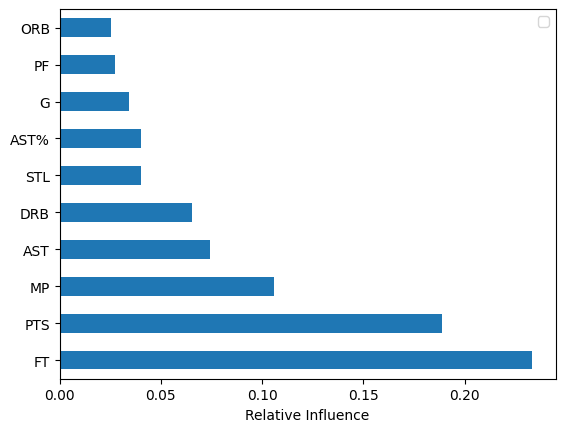

In [37]:
# TOP 10 features
from matplotlib import pyplot as plt

sorted(zip(brf_cv.best_estimator_.feature_importances_,num_vab),reverse=True)
feat_imp = pd.DataFrame({'Relative Influence':brf_cv.best_estimator_.feature_importances_})
feat_imp['Feature'] = num_vab

top_10_obj2 = feat_imp.sort_values(by=['Relative Influence'],ascending=False)[:10]
top_10_obj2.set_index('Feature',drop=True,inplace=True)

top_10_obj2.plot.barh()
plt.xlabel('Relative Influence')
plt.legend('')
plt.ylabel('')



auc = brf_cv.cv_results_['mean_test_AUC']
recall = brf_cv.cv_results_['mean_test_Recall']
for auc, recall, params in zip(auc, recall, brf_cv.cv_results_['params']):
    print(auc,recall,params)

## Compare different parameters' results

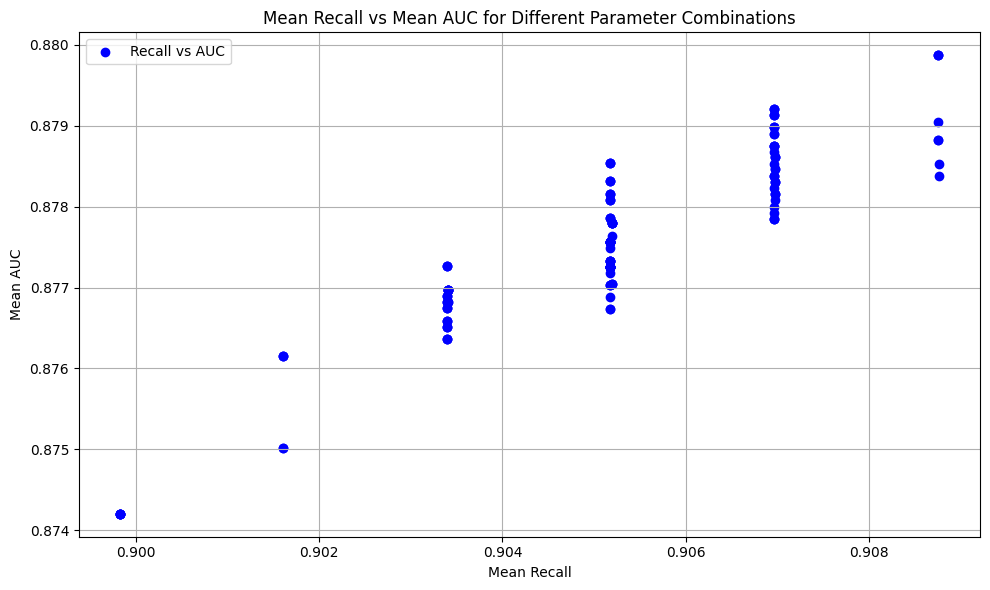

In [38]:
# Extracting parameter combinations and their corresponding scores
params = brf_cv.cv_results_['params']
mean_recall_scores = brf_cv.cv_results_['mean_test_Recall']  # Mean recall scores for each parameter combination
mean_auc_scores = brf_cv.cv_results_['mean_test_AUC']  # Mean AUC scores for each parameter combination

# Extracting individual parameters
max_depth_values = [param['max_depth'] for param in params]
min_samples_leaf_values = [param['min_samples_leaf'] for param in params]
min_samples_split_values = [param['min_samples_split'] for param in params]
n_estimators_values = [param['n_estimators'] for param in params]

# Plotting recall scores against parameter combinations
plt.figure(figsize=(10, 6))
plt.scatter(mean_recall_scores, mean_auc_scores, c='blue', marker='o', label='Recall vs AUC')

plt.title('Mean Recall vs Mean AUC for Different Parameter Combinations')
plt.xlabel('Mean Recall')
plt.ylabel('Mean AUC')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

## Test data

In [ ]:
final_model_obj2 = brf_cv.best_estimator_
y_test_predict = final_model_obj2.predict(x_test_set_processed)
x_test_set_processed.shape
precision_score(y_test,y_test_predict)
recall_score(y_test,y_test_predict)
roc_auc_score(y_test,y_test_predict)
f1_score(y_test,y_test_predict)

0.47744360902255645